In [28]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import importlib
import ml_trading.machine_learning.util

import logging
import datetime, sys, os

date_strftime_format = '%Y-%m-%d %H:%M:%S'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')


from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

logging.basicConfig(stream=sys.stdout, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt=date_strftime_format)

In [29]:
from market_data.feature.impl.common import SequentialFeatureParam

In [30]:
from xgboost import plot_importance
import shap

In [31]:
import market_data.util
import market_data.util.time

time_range = market_data.util.time.TimeRange(
    date_str_from='2024-01-01', date_str_to='2025-04-01',
    )


In [32]:
time_range = market_data.util.time.TimeRange(
    date_str_from='2024-01-01', date_str_to='2024-01-02',
    )

import market_data.feature.cache_reader
importlib.reload(market_data.feature.cache_reader)
featuers_df = market_data.feature.cache_reader.read_multi_feature_cache(
    feature_labels_params=['btc_features'],
    time_range=time_range,
    dataset_mode=market_data.ingest.bq.common.DATASET_MODE.OKX,
    export_mode=market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE,
    aggregation_mode=market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
)

2025-04-16 22:26:05 - INFO - Reading cached feature: btc_features
2025-04-16 22:26:05 - INFO - /Users/junlim/algo_cache/feature_data/features/btc_features/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/periods-1_5_15_30_60_120_price-close/2024-01-01T00:00:00-0500_2024-01-02T00:00:00-0500.parquet exists.
2025-04-16 22:26:05 - INFO - Successfully read 266400 rows for feature 'btc_features'
2025-04-16 22:26:05 - INFO - Joining feature DataFrames on timestamp and symbol
2025-04-16 22:26:05 - INFO - Combined 1 feature sets into DataFrame with 266400 rows


In [17]:
featuers_df.columns

Index(['btc_return_1', 'btc_return_5', 'btc_return_15', 'btc_return_30',
       'btc_return_60', 'btc_return_120'],
      dtype='object')

In [7]:
time_range = market_data.util.time.TimeRange(
    date_str_from='2024-01-02', date_str_to='2024-01-03',
    )


import market_data.machine_learning.cache_ml_data
importlib.reload(market_data.machine_learning.cache_ml_data)
ml_data_df = market_data.machine_learning.cache_ml_data.load_cached_ml_data(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
)

2025-04-16 17:13:28 - INFO - No specific features specified, using all available features with default parameters
2025-04-16 17:13:28 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/r_price_col-close_r_threshold-0.05/t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/bollinger,period-20_price-close_std_dev-2.0/btc_features,periods-1_5_15_30_60_120_price-close/ema,periods-5_15_30_60_120_price-close_rel-True/garch,alpha-0.1_beta-0.8_omega-0.1_price-close_type-ann/indicators,autocorr_lag-1_autocorr_window-14_minmax_window-20_price-close_rsi_period-14_zscore_window-20/market_regime,price-close_stats-mean_var_skew_kurt_windows-240_1440_4320/returns,periods-1_5_15_30_60_120_price-close_type-simple/volatility,price-close_type-ann_windows-5_10_20_30_60/volume,obv_zscore-20_price-close_ratio_periods-20_50_100_volume-volume/2024-01-02T00:00:00-0500_2024-01-03T00:00:00-0500.parquet exists.


In [8]:
ml_data_df

,symbol,return_1,return_5,return_15,return_30,return_60,return_120,volatility_5,volatility_10,volatility_20,...,btc_return_30,btc_return_60,btc_return_120,garch_volatility,label_forward_return_2m,label_forward_return_10m,label_long_tp30_sl30_2m,label_short_tp30_sl30_2m,label_long_tp30_sl30_10m,label_short_tp30_sl30_10m
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-02 09:34:00-05:00,ACE-USDT-SWAP,0.017832,-0.026739,-0.034038,-0.042326,-0.034688,-0.032457,3.267895,1.859398,0.993310,...,-0.002505,-0.000557,-0.001326,426.007146,-0.000100,0.007665,0.0,0.0,0.0,0.0
2024-01-02 11:02:00-05:00,AIDOGE-USDT-SWAP,0.030806,0.046176,0.053269,0.073544,0.072485,0.032764,3.378408,1.725598,0.907289,...,0.003794,0.000183,-0.007890,425.991132,-0.009195,-0.006437,0.0,0.0,0.0,0.0
2024-01-02 11:24:00-05:00,AIDOGE-USDT-SWAP,-0.023037,-0.027154,-0.042396,0.004836,0.029222,-0.012357,1.130507,0.649679,0.977164,...,-0.008347,-0.003745,-0.018948,425.962541,0.012993,0.016843,0.0,0.0,0.0,0.0
2024-01-02 19:00:00-05:00,BAT-USDT-SWAP,0.054104,0.058052,0.064030,0.064832,0.068053,0.080719,0.374956,0.236410,0.166067,...,0.001292,0.001012,-0.001437,425.958306,-0.013097,-0.004956,0.0,0.0,0.0,0.0
2024-01-02 19:01:00-05:00,BAT-USDT-SWAP,-0.006726,0.050543,0.056874,0.060068,0.059668,0.073861,5.737413,3.043834,1.583714,...,0.001250,0.000600,-0.001904,426.082866,-0.007840,0.001069,0.0,0.0,0.0,0.0
2024-01-02 10:50:00-05:00,CETUS-USDT-SWAP,0.036168,0.037702,0.044610,0.042538,0.009312,0.002670,0.711880,0.460249,0.283925,...,-0.000585,-0.005308,-0.010007,425.958999,0.005231,0.013411,0.0,0.0,0.0,0.0
2024-01-02 20:23:00-05:00,CETUS-USDT-SWAP,-0.015269,-0.025930,-0.038009,-0.049201,-0.071224,-0.027435,0.460708,0.387954,0.287360,...,0.000864,0.005517,0.003822,425.959508,-0.004950,0.002522,0.0,0.0,0.0,0.0
2024-01-02 10:15:00-05:00,PERP-USDT-SWAP,-0.012954,0.028643,0.073696,0.077526,0.082699,0.115544,4.242433,2.411236,1.341933,...,-0.008089,-0.015261,-0.009101,426.010957,-0.007981,-0.002719,0.0,0.0,-1.0,1.0


In [56]:
time_range = market_data.util.time.TimeRange(
    date_str_from='2024-11-02', date_str_to='2024-12-03',
    )


import market_data.machine_learning.cache_ml_data
importlib.reload(market_data.machine_learning.cache_ml_data)
ml_data_seq_df = market_data.machine_learning.cache_ml_data.load_cached_ml_data(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    seq_params = SequentialFeatureParam(),
)

2025-04-16 22:32:50 - INFO - No specific features specified, using all available features with default parameters
2025-04-16 22:32:50 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/sequence_window-60/r_price_col-close_r_threshold-0.05/t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/bollinger,period-20_price-close_std_dev-2.0/btc_features,periods-1_5_15_30_60_120_price-close/ema,periods-5_15_30_60_120_price-close_rel-True/garch,alpha-0.1_beta-0.8_omega-0.1_price-close_type-ann/indicators,autocorr_lag-1_autocorr_window-14_minmax_window-20_price-close_rsi_period-14_zscore_window-20/market_regime,price-close_stats-mean_var_skew_kurt_windows-240_1440_4320/returns,periods-1_5_15_30_60_120_price-close_type-simple/volatility,price-close_type-ann_windows-5_10_20_30_60/volume,obv_zscore-20_price-close_ratio_periods-20_50_100_volume-volume/2024-11-02T00:00:00-0400_2024-11-03T00:00:00-0400.parquet exists.
2025-04-16

In [57]:
ml_data_seq_df

,symbol,return_1,return_5,return_15,return_30,return_60,return_120,volatility_5,volatility_10,volatility_20,...,btc_return_30,btc_return_60,btc_return_120,garch_volatility,label_forward_return_2m,label_forward_return_10m,label_long_tp30_sl30_2m,label_short_tp30_sl30_2m,label_long_tp30_sl30_10m,label_short_tp30_sl30_10m
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-11-02 02:07:00-04:00,X-USDT-SWAP,"[0.002619047619047743, 0.0016623129897885836, ...","[-0.0004747211013528263, 0.0038077106139933203...","[-0.007307873644507246, -0.004953998584571795,...","[0.0019034023316677473, 0.003330161750713545, ...","[-0.008009422850412284, -0.005423249233671323,...","[-0.022062238736646478, -0.022026431718061734,...","[0.28894075015594234, 0.4647162628728744, 0.34...","[0.22872724926868448, 0.2851131447045901, 0.29...","[0.2021713786703832, 0.21965950562780293, 0.22...",...,"[-0.0005526587346706968, -0.000577111277416442...","[-0.001124822178846907, -0.001124822178846907,...","[-0.004245770002867855, -0.0044170776465192185...","[425.9581435389524, 425.95835588940656, 425.95...",-0.001589,-0.004995,0.0,0.0,0.0,0.0
2024-11-02 02:37:00-04:00,GRASS-USDT-SWAP,"[-0.0031713118253338113, 0.0025084123585195073...","[-0.008432419315700046, -0.007570710435467198,...","[0.0015318627450982003, 0.0048445452873000505,...","[-0.024295606494746824, -0.02638146167557931, ...","[0.012826868261246904, 0.009052281544430274, 0...","[0.05349661617789225, 0.056615940159917555, 0....","[0.9816771346956665, 0.949896892961831, 0.9975...","[0.8004472998422872, 0.8066186121794935, 0.784...","[0.6089816970128844, 0.5308364594602762, 0.532...",...,"[0.0026741009649517977, 0.0026741009649517977,...","[0.002119964365025373, 0.002095446433711512, 0...","[8.04320349305776e-05, 8.04320349305776e-05, 0...","[425.9617210613142, 425.96135412025995, 425.96...",0.005526,0.023487,0.0,0.0,1.0,-1.0
2024-11-02 05:15:00-04:00,GRASS-USDT-SWAP,"[-0.005513033238773168, -0.003283100107642656,...","[0.0025360168348351753, -0.007024128686327069,...","[0.014801463760991895, 0.008495343898055951, 0...","[-0.007266509938020804, -0.00403355921264914, ...","[0.015800120277732255, 0.011414527580557055, 0...","[0.08534377008002814, 0.07275676301917411, 0.0...","[1.3345241857579735, 1.3764896621509626, 1.161...","[0.8615648077669147, 0.9242365939521909, 0.865...","[0.7946682931778407, 0.6995242900653249, 0.695...",...,"[-0.0006308786418903756, -0.001204542847309864...","[-6.74273040411899e-05, -0.0007560465793554627...","[0.0016281846962136193, 0.001158522036354137, ...","[425.9630270916138, 425.9632651765369, 425.962...",-0.012132,-0.024047,0.0,0.0,-1.0,1.0
2024-11-02 06:10:00-04:00,GRASS-USDT-SWAP,"[0.008960675760516068, -0.0024324018554134907,...","[0.023861925170856058, 0.013331034879043857, -...","[-0.0009607233681830918, -0.002488828553651179...","[0.013646788990825609, 0.0035852492601866626, ...","[-0.046133923272001276, -0.054423592493297535,...","[-0.032773431088253036, -0.031043956043956045,...","[1.6572830549677808, 1.7516445306499953, 1.832...","[1.2579021579971665, 1.1263106348692116, 1.092...","[0.8288328097918117, 0.8727771390982223, 0.875...",...,"[0.0003592573432200652, 0.0003592573432200652,...","[-0.001935539370304551, -0.0017051019691129987...","[-0.0017008070946314957, -0.001706533585728253...","[425.9677418574753, 425.9691624762019, 425.967...",-0.005336,-0.007514,0.0,0.0,-1.0,1.0
2024-11-02 09:34:00-04:00,X-USDT-SWAP,"[0.0034618047542118724, 0.005979760809567747, ...","[0.0034618047542118724, 0.006906077348066253, ...","[0.004853247053385745, 0.013673232908458788, 0...","[0.004621072088724532, 0.011329479768785955, 0...","[-0.005034324942791768, -0.000913659205116435,...","[-0.0022946305644792053, 0.0006863417982154729...","[0.6704396788482607, 0.7524263862332102, 0.942...","[0.4749548719964867, 0.5025351759848753, 0.583...","[0.3376530212457141, 0.35155046760892134, 0.38...",...,"[-0.001953012809466359, -0.0009621460164283002...","[-0.0017236426314277686, -0.000732548118356768...","[0.0

In [58]:
ml_data_seq_df.shape

(1850, 52)

In [10]:
ml_data_df

,symbol,return_1,return_5,return_15,return_30,return_60,return_120,volatility_5,volatility_10,volatility_20,...,btc_return_30,btc_return_60,btc_return_120,garch_volatility,label_forward_return_2m,label_forward_return_10m,label_long_tp30_sl30_2m,label_short_tp30_sl30_2m,label_long_tp30_sl30_10m,label_short_tp30_sl30_10m
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-02 09:34:00-05:00,ACE-USDT-SWAP,0.017832,-0.026739,-0.034038,-0.042326,-0.034688,-0.032457,3.267895,1.859398,0.993310,...,-0.002505,-0.000557,-0.001326,426.007146,-0.000100,0.007665,0.0,0.0,0.0,0.0
2024-01-02 11:02:00-05:00,AIDOGE-USDT-SWAP,0.030806,0.046176,0.053269,0.073544,0.072485,0.032764,3.378408,1.725598,0.907289,...,0.003794,0.000183,-0.007890,425.991132,-0.009195,-0.006437,0.0,0.0,0.0,0.0
2024-01-02 11:24:00-05:00,AIDOGE-USDT-SWAP,-0.023037,-0.027154,-0.042396,0.004836,0.029222,-0.012357,1.130507,0.649679,0.977164,...,-0.008347,-0.003745,-0.018948,425.962541,0.012993,0.016843,0.0,0.0,0.0,0.0
2024-01-02 19:00:00-05:00,BAT-USDT-SWAP,0.054104,0.058052,0.064030,0.064832,0.068053,0.080719,0.374956,0.236410,0.166067,...,0.001292,0.001012,-0.001437,425.958306,-0.013097,-0.004956,0.0,0.0,0.0,0.0
2024-01-02 19:01:00-05:00,BAT-USDT-SWAP,-0.006726,0.050543,0.056874,0.060068,0.059668,0.073861,5.737413,3.043834,1.583714,...,0.001250,0.000600,-0.001904,426.082866,-0.007840,0.001069,0.0,0.0,0.0,0.0
2024-01-02 10:50:00-05:00,CETUS-USDT-SWAP,0.036168,0.037702,0.044610,0.042538,0.009312,0.002670,0.711880,0.460249,0.283925,...,-0.000585,-0.005308,-0.010007,425.958999,0.005231,0.013411,0.0,0.0,0.0,0.0
2024-01-02 20:23:00-05:00,CETUS-USDT-SWAP,-0.015269,-0.025930,-0.038009,-0.049201,-0.071224,-0.027435,0.460708,0.387954,0.287360,...,0.000864,0.005517,0.003822,425.959508,-0.004950,0.002522,0.0,0.0,0.0,0.0
2024-01-02 10:15:00-05:00,PERP-USDT-SWAP,-0.012954,0.028643,0.073696,0.077526,0.082699,0.115544,4.242433,2.411236,1.341933,...,-0.008089,-0.015261,-0.009101,426.010957,-0.007981,-0.002719,0.0,0.0,-1.0,1.0


In [203]:
import ml_trading.machine_learning.validation_data
importlib.reload(ml_trading.machine_learning.validation_data)

'''
data_sets = ml_trading.machine_learning.validation_data.create_train_validation_test_splits(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    fixed_window_size = datetime.timedelta(days=150),
    step_size = datetime.timedelta(days=30),
    purge_period = datetime.timedelta(minutes=30),
    embargo_period = datetime.timedelta(days=1),
    split_ratio = [0.8, 0.2, 0.0],
)
#'''


#'''
data_sets = ml_trading.machine_learning.validation_data.create_split_moving_forward(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    initial_training_fixed_window_size = datetime.timedelta(days=150),
    purge_period = datetime.timedelta(minutes=30),
    embargo_period = datetime.timedelta(days=1),
    step_event_size = 300,
    validation_fixed_event_size = 300,
    test_fixed_event_size= 0,
)
#'''


2025-04-12 09:23:11 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/f_add_btc_features-True_f_ema_periods-5_15_30_60_120_240_f_return_periods-1_5_15_30_60_120_f_volatility_windows-240_r_price_col-close_r_threshold-0.05_t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/2024-01-01T00:00:00-0500_2024-01-02T00:00:00-0500.parquet exists.
2025-04-12 09:23:11 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/f_add_btc_features-True_f_ema_periods-5_15_30_60_120_240_f_return_periods-1_5_15_30_60_120_f_volatility_windows-240_r_price_col-close_r_threshold-0.05_t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/2024-01-02T00:00:00-0500_2024-01-03T00:00:00-0500.parquet exists.
2025-04-12 09:23:11 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/f_add_btc_features-True_f_ema

In [204]:
importlib.reload(ml_trading.machine_learning.util)

<module 'ml_trading.machine_learning.util' from '/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py'>

In [205]:
import ml_trading.models.model

metrics_list = []
all_validation_dfs = []

for i, (train_df, validation_df, test_df) in enumerate(data_sets):
    print(f"\n########################################################")
    print(f"Training model {i+1} of {len(data_sets)}")
    print(f'train: {len(train_df)}\n{train_df.head(1).index}\n{train_df.tail(1).index}')
    print(f'validation: {len(validation_df)}\n{validation_df.head(1).index}\n{validation_df.tail(1).index}')
    #print(f'test: {len(test_df)}\n{test_df.head(1).index}\n{test_df.tail(1).index}')

    model, metrics, validation_y_df = ml_trading.models.model.train_xgboost_model(
        #ml_data_df, 
        train_df=train_df,
        validation_df=validation_df,
        target_column='label_long_tp30_sl30_10m',
        prediction_threshold=0.70)
    metrics_list.append(metrics)
    
    # Add model number for tracking
    validation_y_df['model_num'] = i+1
    all_validation_dfs.append(validation_y_df)

# Print metrics summary
for i, metrics in enumerate(metrics_list):
    print(f"{i+1}, non_zero_accuracy: {metrics['non_zero_accuracy']}")

combined_validation_df = ml_trading.machine_learning.util.combine_validation_dfs(all_validation_dfs)


########################################################
Training model 1 of 26
train: 3708
DatetimeIndex(['2024-01-01 00:28:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-05-30 01:26:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
validation: 300
DatetimeIndex(['2024-05-31 12:01:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-06-07 15:04:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)

Test set target label distribution:
Total samples: 300
Positive returns: 157 (52.33%)
Negative returns: 98 (32.67%)
Neutral returns: 45 (15.00%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 157
Predicted as positive: 48 (30.57%)
Predicted as neutral: 107 (68.15%)
Predicted as negative: 2 (1.27%)


Total neutral labels: 45
Predicted as positive: 2 (4.44%)
Predicted as neutral: 43 (95.56%)
Predicted as

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),


accuracy: 0.32
mae: 0.69
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.30
neutral_recall: 1.00
non_zero_accuracy: 0.80
positive_precision: 0.80
positive_recall: 0.07
r2: -0.03

########################################################
Training model 3 of 26
train: 3708
DatetimeIndex(['2024-01-21 22:57:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-06-17 21:43:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
validation: 300
DatetimeIndex(['2024-06-18 23:27:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-08-04 21:09:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)

Test set target label distribution:
Total samples: 300
Positive returns: 61 (20.33%)
Negative returns: 93 (31.00%)
Neutral returns: 146 (48.67%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 61
Predicted as 

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 71
Predicted as positive: 1 (1.41%)
Predicted as neutral: 70 (98.59%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 157
Predicted as positive: 0 (0.00%)
Predicted as neutral: 157 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 72
Predicted as positive: 0 (0.00%)
Predicted as neutral: 72 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 70 (23.41%)
Actually neutral: 157 (52.51%)
Actually negative: 72 (24.08%)


Total negative predictions: 0
accuracy: 0.53
mae: 0.50
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.53
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_precision: 1.00
positive_recall: 0.01
r2: -0.02

#################################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),


accuracy: 0.47
mae: 0.55
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.47
neutral_recall: 0.99
non_zero_accuracy: 0.00
positive_precision: 0.00
positive_recall: 0.00
r2: -0.04

########################################################
Training model 8 of 26
train: 3708
DatetimeIndex(['2024-03-11 03:00:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-11-09 09:07:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
validation: 300
DatetimeIndex(['2024-11-10 09:44:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-11-14 04:04:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)

Test set target label distribution:
Total samples: 300
Positive returns: 84 (28.00%)
Negative returns: 93 (31.00%)
Neutral returns: 123 (41.00%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as 

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 105
Predicted as positive: 1 (0.95%)
Predicted as neutral: 104 (99.05%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 136
Predicted as positive: 0 (0.00%)
Predicted as neutral: 136 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 59
Predicted as positive: 0 (0.00%)
Predicted as neutral: 59 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 104 (34.78%)
Actually neutral: 136 (45.48%)
Actually negative: 59 (19.73%)


Total negative predictions: 0
accuracy: 0.46
mae: 0.56
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.45
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_precision: 1.00
positive_recall: 0.01
r2: -0.09

##############################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 100
Predicted as positive: 14 (14.00%)
Predicted as neutral: 86 (86.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 129
Predicted as positive: 0 (0.00%)
Predicted as neutral: 129 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 71
Predicted as positive: 0 (0.00%)
Predicted as neutral: 69 (97.18%)
Predicted as negative: 2 (2.82%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 14
Actually positive: 14 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 284
Actually positive: 86 (30.28%)
Actually neutral: 129 (45.42%)
Actually negative: 69 (24.30%)


Total negative predictions: 2
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 2 (100.00%)

accuracy: 0.48
mae: 0.52
negative_precision: 1.00
negative_recall: 0.03
neutral_precision: 0.45
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_prec

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 60
Predicted as positive: 1 (1.67%)
Predicted as neutral: 59 (98.33%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 176
Predicted as positive: 0 (0.00%)
Predicted as neutral: 176 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 64
Predicted as positive: 0 (0.00%)
Predicted as neutral: 64 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 59 (19.73%)
Actually neutral: 176 (58.86%)
Actually negative: 64 (21.40%)


Total negative predictions: 0
accuracy: 0.59
mae: 0.44
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.59
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_precision: 1.00
positive_recall: 0.02
r2: -0.06

#################################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 94
Predicted as positive: 21 (22.34%)
Predicted as neutral: 73 (77.66%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 125
Predicted as positive: 1 (0.80%)
Predicted as neutral: 124 (99.20%)
Predicted as negative: 0 (0.00%)


Total negative labels: 81
Predicted as positive: 3 (3.70%)
Predicted as neutral: 78 (96.30%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 25
Actually positive: 21 (84.00%)
Actually neutral: 1 (4.00%)
Actually negative: 3 (12.00%)


Total neutral predictions: 275
Actually positive: 73 (26.55%)
Actually neutral: 124 (45.09%)
Actually negative: 78 (28.36%)


Total negative predictions: 0
accuracy: 0.48
mae: 0.55
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.45
neutral_recall: 0.99
non_zero_accuracy: 0.84
positive_precision: 0.84
positive_recall: 0.22
r2: 0.07

################################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as positive: 0 (0.00%)
Predicted as neutral: 84 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 154
Predicted as positive: 0 (0.00%)
Predicted as neutral: 154 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 62
Predicted as positive: 0 (0.00%)
Predicted as neutral: 62 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 300
Actually positive: 84 (28.00%)
Actually neutral: 154 (51.33%)
Actually negative: 62 (20.67%)


Total negative predictions: 0
accuracy: 0.51
mae: 0.53
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.51
neutral_recall: 1.00
non_zero_accuracy: 0.00
positive_precision: nan
positive_recall: 0.00
r2: -0.09

########################################################
Training model 19 of 26
train: 3708
DatetimeIndex(['2024-10-14 16:17:00-04:00'], 

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 74
Predicted as positive: 0 (0.00%)
Predicted as neutral: 73 (98.65%)
Predicted as negative: 1 (1.35%)


Total neutral labels: 155
Predicted as positive: 0 (0.00%)
Predicted as neutral: 155 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 71
Predicted as positive: 0 (0.00%)
Predicted as neutral: 70 (98.59%)
Predicted as negative: 1 (1.41%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 298
Actually positive: 73 (24.50%)
Actually neutral: 155 (52.01%)
Actually negative: 70 (23.49%)


Total negative predictions: 2
Actually positive: 1 (50.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (50.00%)

accuracy: 0.52
mae: 0.51
negative_precision: 0.50
negative_recall: 0.01
neutral_precision: 0.52
neutral_recall: 1.00
non_zero_accuracy: 0.50
positive_precision: nan
positive_recall: 0.00
r2: -0.03

##################################################

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),
/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),



########################################################
Training model 21 of 26
train: 3708
DatetimeIndex(['2024-11-12 05:49:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2025-02-11 17:17:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
validation: 300
DatetimeIndex(['2025-02-12 17:19:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2025-02-22 08:13:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)

Test set target label distribution:
Total samples: 300
Positive returns: 75 (25.00%)
Negative returns: 91 (30.33%)
Neutral returns: 134 (44.67%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 75
Predicted as positive: 0 (0.00%)
Predicted as neutral: 73 (97.33%)
Predicted as negative: 2 (2.67%)


Total neutral labels: 134
Predicted as positive: 0 (0.00%)
Predicted as neutral: 134 (100.00%)
Predicted as

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 74
Predicted as positive: 1 (1.35%)
Predicted as neutral: 71 (95.95%)
Predicted as negative: 2 (2.70%)


Total neutral labels: 149
Predicted as positive: 0 (0.00%)
Predicted as neutral: 148 (99.33%)
Predicted as negative: 1 (0.67%)


Total negative labels: 77
Predicted as positive: 0 (0.00%)
Predicted as neutral: 74 (96.10%)
Predicted as negative: 3 (3.90%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 293
Actually positive: 71 (24.23%)
Actually neutral: 148 (50.51%)
Actually negative: 74 (25.26%)


Total negative predictions: 6
Actually positive: 2 (33.33%)
Actually neutral: 1 (16.67%)
Actually negative: 3 (50.00%)

accuracy: 0.51
mae: 0.53
negative_precision: 0.50
negative_recall: 0.04
neutral_precision: 0.51
neutral_recall: 0.99
non_zero_accuracy: 0.57
positive_precision

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:77: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_discrete == -1) & (y_test < 0)) / np.sum(y_pred_discrete == -1),



=== Recall Breakdown (by actual label) ===

Total positive labels: 71
Predicted as positive: 2 (2.82%)
Predicted as neutral: 69 (97.18%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 165
Predicted as positive: 0 (0.00%)
Predicted as neutral: 165 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 64
Predicted as positive: 0 (0.00%)
Predicted as neutral: 62 (96.88%)
Predicted as negative: 2 (3.12%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 2
Actually positive: 2 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 296
Actually positive: 69 (23.31%)
Actually neutral: 165 (55.74%)
Actually negative: 62 (20.95%)


Total negative predictions: 2
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 2 (100.00%)

accuracy: 0.56
mae: 0.45
negative_precision: 1.00
negative_recall: 0.03
neutral_precision: 0.56
neutral_recall: 1.00
non_zero_accuracy: 1.00
positive_precision

/Users/junlim/projects/ml_trading/ml_trading/models/util.py:73: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_discrete == 1) & (y_test > 0)) / np.sum(y_pred_discrete == 1),


In [206]:
importance = model.feature_importances_
pd.Series(importance, index=[c for c in train_df.columns if not c.startswith('label_') and c != 'symbol']).sort_values(ascending=False)

btc_return_120      0.148260
btc_return_1        0.137647
btc_return_60       0.105177
btc_return_30       0.072020
btc_return_5        0.062520
ema_rel_60          0.040207
ema_rel_120         0.037863
btc_return_15       0.032757
ema_rel_30          0.022465
garch_volatility    0.019741
ema_rel_5           0.015890
ema_rel_15          0.015567
return_30           0.014390
rsi                 0.012993
volatility_10       0.012543
open_close_ratio    0.012239
bb_position         0.012165
ema_5               0.011529
bb_lower            0.011317
volume_ratio_20     0.011208
return_15           0.010862
return_120          0.010784
volume_ratio_100    0.010758
volatility_30       0.010439
close_zscore        0.010083
bb_width            0.010049
obv_zscore          0.010049
volatility_20       0.009659
volatility_60       0.009434
hl_range_pct        0.009265
close_minmax        0.009133
true_range          0.009011
autocorr_lag1       0.008877
volume_ratio_50     0.008438
ema_120       

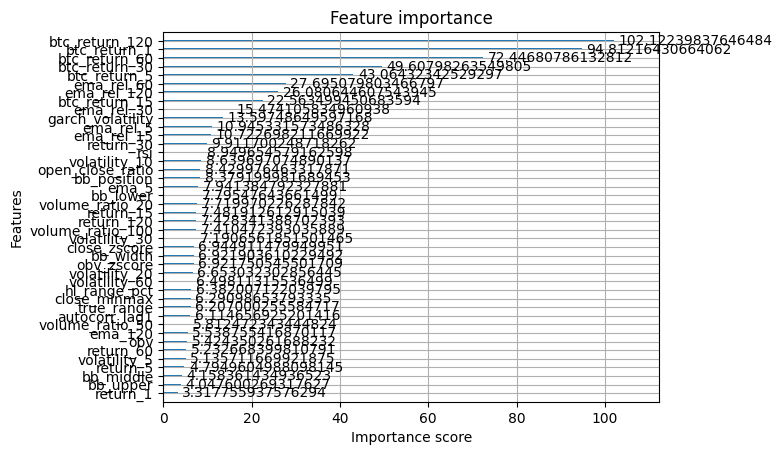

In [207]:
plot_importance(model, importance_type='gain')  # can also be 'weight', 'cover', 'total_gain', etc.
plt.show()

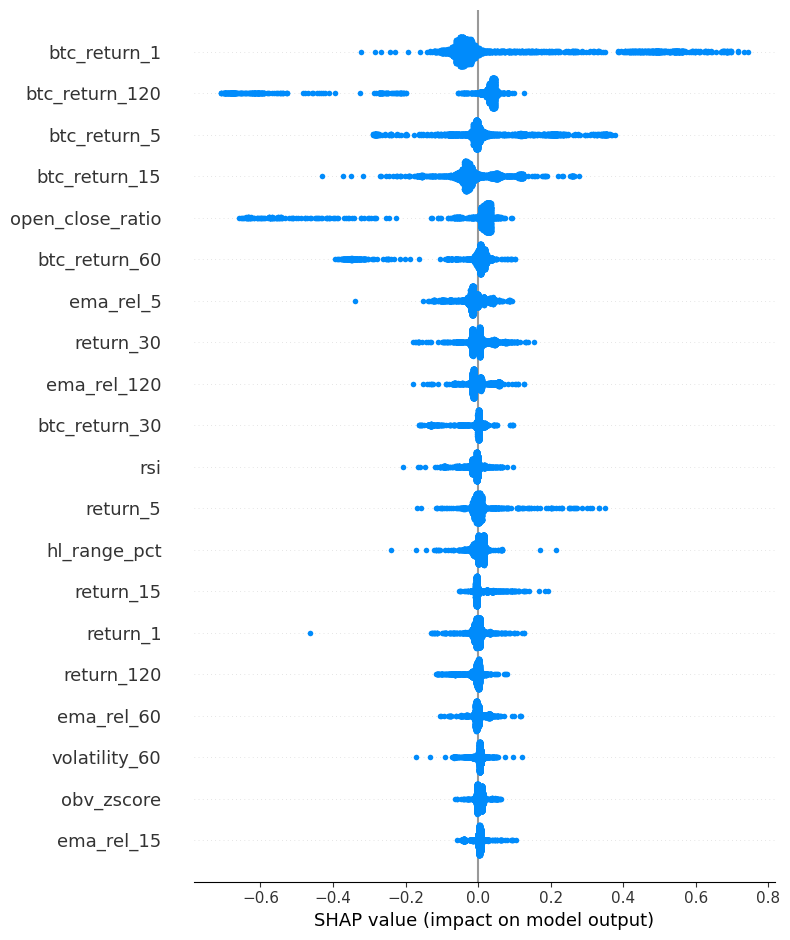

In [208]:
explainer = shap.Explainer(model)
shap_values = explainer(train_df[[c for c in train_df.columns if not c.startswith('label_') and c != 'symbol']])

shap.summary_plot(shap_values, [[c for c in train_df.columns if not c.startswith('label_') and c != 'symbol']])

In [209]:
# Example usage:
if 'combined_validation_df' in locals():
    # Calculate with different thresholds for comparison
    trade_results_conservative = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.8)
    trade_results = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df)
    trade_results_aggressive = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.5)
#'''


Trade statistics (threshold=0.8):
Total trades: 101
Average return per trade: 0.6238
Win rate: 79.21%, loss: 16.83%, draw: 3.96%
Total return: 63.0000

Trade statistics (threshold=0.7):
Total trades: 172
Average return per trade: 0.5640
Win rate: 75.58%, loss: 19.19%, draw: 5.23%
Total return: 97.0000

Trade statistics (threshold=0.5):
Total trades: 406
Average return per trade: 0.2980
Win rate: 61.58%, loss: 31.77%, draw: 6.65%
Total return: 121.0000


In [210]:
trade_results['date'] = trade_results.index.get_level_values('timestamp').strftime("%Y-%m-%d")

<Axes: xlabel='date'>

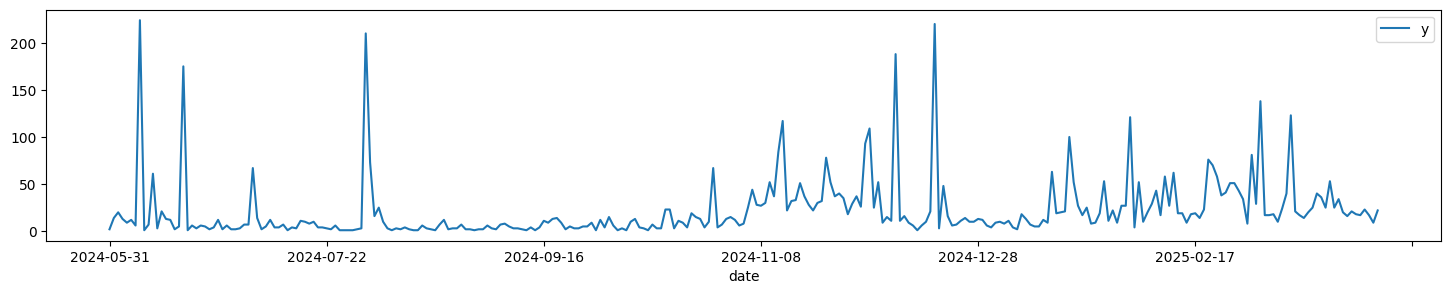

In [211]:
trade_results.groupby(["date"])[["y"]].count().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

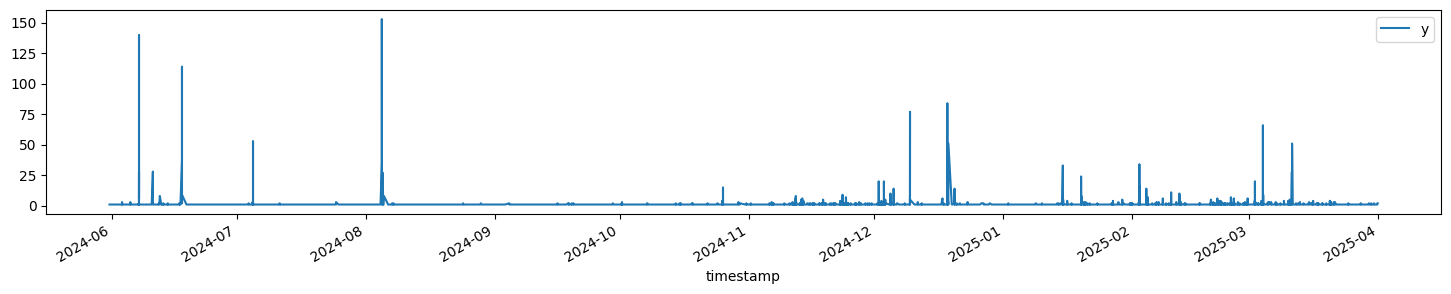

In [212]:
trade_results.groupby(["timestamp"])[["y"]].count().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

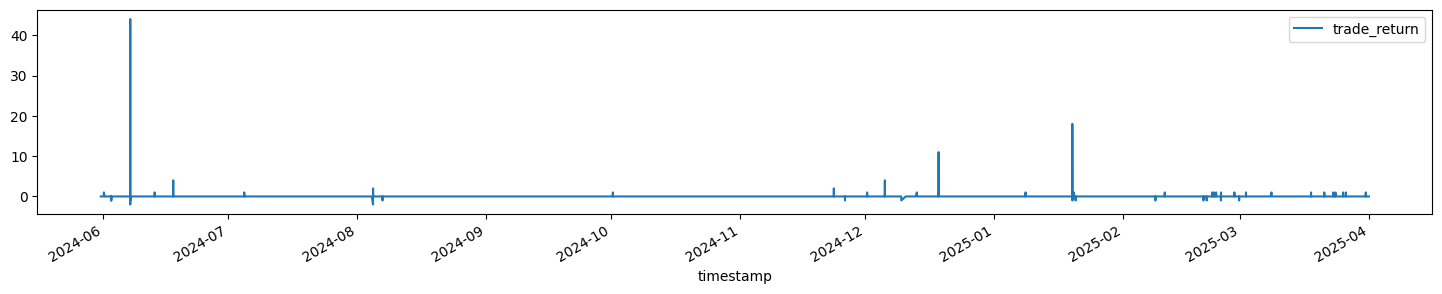

In [213]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

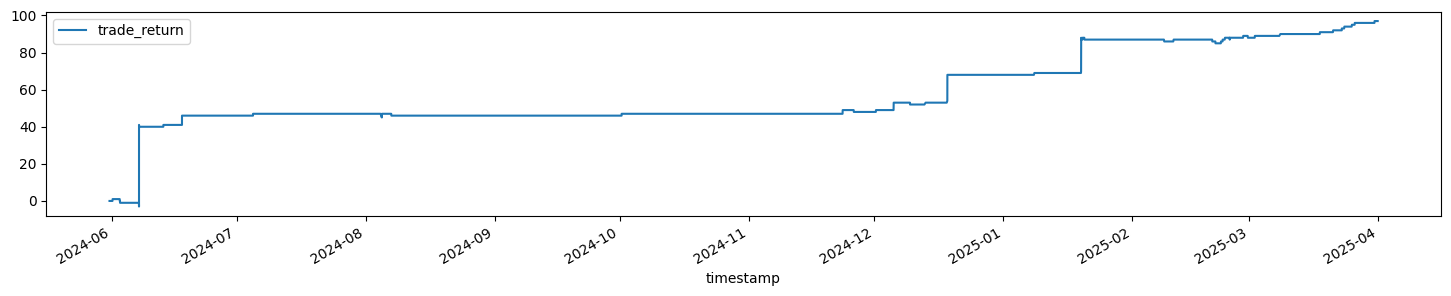

In [214]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

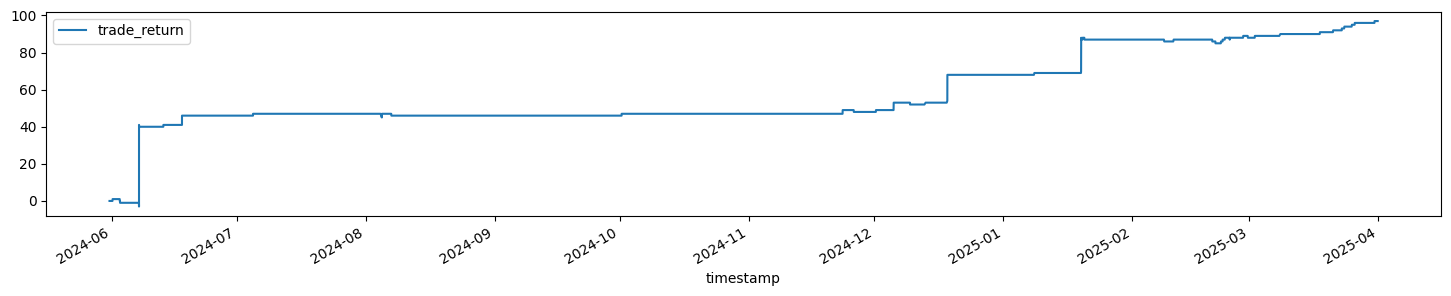

In [216]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))